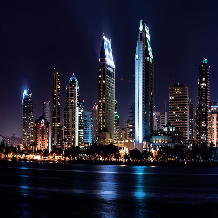

In [44]:
import tensorflow as tf
import numpy as np
from PIL import Image, ImageGrab #allows us to manage image related operations
from io import BytesIO # io module allows us to manage the file-related input and output operations
import requests #used to send http requests through python
import matplotlib.pyplot as plt
san_francisco_image_path = "https://create.adobe.com/content/microsites/inspire/en/2018/3/30/getting_into_night_p/_jcr_content/article-marquee.img.jpg/1522368774331.jpg" #define path of image

#Input visualization 
input_image = Image.open(BytesIO(requests.get(san_francisco_image_path).content)) #Image.open opens images and metadata, BytesIO deals with the reading and writing of bytes to a stream, requests allows us to send http request using python, we get the content from the sent http request through .content
input_image = input_image.resize((218, 218)) #input resouution of image to resize
input_image.save("img.png","PNG") #input image name and format to be saved in
input_image

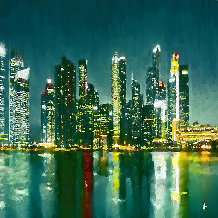

In [45]:
tytus_image_path = "https://images.fineartamerica.com/images/artworkimages/mediumlarge/1/singapore-skyline-painting-river-painting-oil-painting-original-urban-painting-cityscape-vya-artist.jpg"

# Style visualization 
style_image = Image.open(BytesIO(requests.get(tytus_image_path).content))
style_image = style_image.resize((218, 218))
style_image.save("style.png","PNG")
style_image

In [46]:
import keras
from keras import backend
from keras.models import Model
from keras.applications.vgg16 import VGG16
IMAGENET_MEAN_RGB_VALUES = [123.68, 116.779, 103.939]

input_image_array = np.asarray(input_image, dtype="float32") #converting images into arrays
input_image_array = np.expand_dims(input_image_array, axis=0) #expands the array by inserting a new axis at the specified position
input_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2] #Subtracting the dataset mean serves to "center" the data, we do this so that gradients don't go out of control during backpropogation
input_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
input_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
input_image_array = input_image_array[:, :, :, ::-1]

style_image_array = np.asarray(style_image, dtype="float32")
style_image_array = np.expand_dims(style_image_array, axis=0)
style_image_array[:, :, :, 0] -= IMAGENET_MEAN_RGB_VALUES[2]
style_image_array[:, :, :, 1] -= IMAGENET_MEAN_RGB_VALUES[1]
style_image_array[:, :, :, 2] -= IMAGENET_MEAN_RGB_VALUES[0]
style_image_array = style_image_array[:, :, :, ::-1]

In [47]:
input_image = backend.variable(input_image_array) #Saves matrix representation of image in variable input_image
style_image = backend.variable(style_image_array) #Saves matrix representation of image in variable style_image
combination_image = backend.placeholder((1, 218, 218, 3))  #representes a placeholder tensor and returns it; shape, image width/image hieght and type as input 

input_tensor = backend.concatenate([input_image,style_image,combination_image], axis=0) #concatenates a list of tensors alongside the specified axis.
model = VGG16(input_tensor=input_tensor, include_top=False) #model available in keras, trained on imagenet database, we only use convolve and maxpool layer as fully connected and softmax layer of this model are not needed since they act as classifiers

In [48]:
def content_loss(content, combination): #this function minimize the distance b/w i/p image and o/p image
    return backend.sum(backend.square(combination - content)) #sum of squared errors is taken as loss function

layers = dict([(layer.name, layer.output) for layer in model.layers]) #dictionary of layers used in model

content_layer = "block2_conv2" #2D convolutional layer
layer_features = layers[content_layer]
content_image_features = layer_features[0, :, :, :] #features of content image
combination_features = layer_features[2, :, :, :] #features of combination image

contentweight = 0.02
loss = backend.variable(0.)
loss = loss +  contentweight * content_loss(content_image_features,
                                      combination_features) #content loss is content weight multiplied by mean squared error


In [49]:
def gram_matrix(x):
    features = backend.batch_flatten(backend.permute_dimensions(x, (2, 0, 1)))  #turns nD tensor into 2D tensor with same 0th dimension
    gram = backend.dot(features, backend.transpose(features)) #dot product of features and transpose of features
    return gram
  
def compute_style_loss(style, combination): #this function minimize the distance b/w style image and o/p image
    style = gram_matrix(style)
    combination = gram_matrix(combination)
    size = 218 * 218
    return backend.sum(backend.square(style - combination)) / (4. * (3 ** 2) * (size ** 2)) #distance b/w style image and o/p image

style_layers = ["block1_conv2", "block2_conv2", "block3_conv3", "block4_conv3", "block5_conv3"] 
for layer_name in style_layers:
    layer_features = layers[layer_name]
    style_features = layer_features[1, :, :, :]
    combination_features = layer_features[2, :, :, :]
    style_loss = compute_style_loss(style_features, combination_features)
    loss += (4.5 / len(style_layers)) * style_loss

In [50]:
IMAGE_HEIGHT = 218
IMAGE_WIDTH = 218
def total_variation_loss(x): #spatial smoother to regularize image and prevent denoising
    a = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, 1:, :IMAGE_WIDTH-1, :])
    b = backend.square(x[:, :IMAGE_HEIGHT-1, :IMAGE_WIDTH-1, :] - x[:, :IMAGE_HEIGHT-1, 1:, :])
    return backend.sum(backend.pow(a + b, 1.25))

loss = loss + 0.995 * total_variation_loss(combination_image)

In [51]:
outputs = [loss]
outputs += backend.gradients(loss, combination_image)

def evaluate_loss_and_gradients(x): #number of iterations to minimize global loss
    x = x.reshape((1, IMAGE_HEIGHT, IMAGE_WIDTH, 3))
    outs = backend.function([combination_image], outputs)([x])
    loss = outs[0]
    gradients = outs[1].flatten().astype("float64")
    return loss, gradients

class Evaluator:

    def loss(self, x):
        loss, gradients = evaluate_loss_and_gradients(x)
        self._gradients = gradients
        return loss

    def gradients(self, x):
        return self._gradients

evaluator = Evaluator()

Iteration 0 completed with loss 55939719168
Iteration 1 completed with loss 23575296000
Iteration 2 completed with loss 14512302080
Iteration 3 completed with loss 11127390208
Iteration 4 completed with loss 9324732416
Iteration 5 completed with loss 8134684672
Iteration 6 completed with loss 7456844800
Iteration 7 completed with loss 6997175808
Iteration 8 completed with loss 6643727872
Iteration 9 completed with loss 6408080896


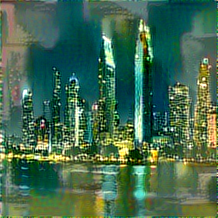

In [52]:
input_image_path = "input.png"
style_image_path = "style.png"
output_image_path = "output.png"
combined_image_path = "combined.png"

from scipy.optimize import fmin_l_bfgs_b #optimize with lbfgs algorithm
x = np.random.uniform(0, 255, (1, IMAGE_HEIGHT, IMAGE_WIDTH, 3)) - 128.

for i in range(10): 
    x, loss, info = fmin_l_bfgs_b(evaluator.loss, x.flatten(), fprime=evaluator.gradients, maxfun=20)
    print("Iteration %d completed with loss %d" % (i, loss))
    
x = x.reshape((IMAGE_HEIGHT, IMAGE_WIDTH, 3))
x = x[:, :, ::-1]
x[:, :, 0] += IMAGENET_MEAN_RGB_VALUES[2]
x[:, :, 1] += IMAGENET_MEAN_RGB_VALUES[1]
x[:, :, 2] += IMAGENET_MEAN_RGB_VALUES[0]
x = np.clip(x, 0, 255).astype("uint8")
output_image = Image.fromarray(x)
output_image.save(output_image_path)
output_image

#The algorithm starts with an initial estimate of the optimal value, {\displaystyle \mathbf {x} _{0}} \mathbf {x} _{0}, 
#and proceeds iteratively to refine that estimate with a sequence of better estimates 
#{\displaystyle \mathbf {x} _{1},\mathbf {x} _{2},\ldots } {\displaystyle \mathbf {x} _{1},\mathbf {x} _{2},\ldots }. 
#The derivatives of the function {\displaystyle g_{k}:=\nabla f(\mathbf {x} _{k})} {\displaystyle g_{k}:=\nabla f(\mathbf {x} _{k})}
#are used as a key driver of the algorithm to identify the direction of steepest descent, 
#and also to form an estimate of the Hessian matrix (second derivative) of {\displaystyle f(\mathbf {x} )} f(\mathbf {x} ).